In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Specify each path

In [2]:
data_directory = "../../../data/"
train_dataset = f'{data_directory}train.csv'
test_dataset = f'{data_directory}test.csv'
model_save_path = './symbol_classifier.keras'
tflite_save_path = './symbol_classifier.tflite'

# Set number of classes

In [3]:
RANDOM_SEED = 42
NUM_CLASSES = 58
MULTI_HAND_LANDMARKS = 126

# Dataset reading

In [4]:
X_train = np.loadtxt(train_dataset, delimiter=',', dtype='float32', usecols=list(range(1, MULTI_HAND_LANDMARKS + 1)))
X_test_data = np.loadtxt(test_dataset, delimiter=',', dtype='float32', usecols=list(range(1, MULTI_HAND_LANDMARKS + 1)))

In [5]:
y_train = np.loadtxt(train_dataset, delimiter=',', dtype='int32', usecols=(0))
y_test_data = np.loadtxt(test_dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_data, y_test_data, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
print(np.unique(y_train))
print(np.unique(y_test))
print(np.unique(y_valid))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]


In [8]:
print(X_train.shape)
print(y_train.shape)

(24241, 126)
(24241,)


# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((126, )),
    # tf.keras.layers.BatchNormalization(),  # Normalizes input features
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout for regularization
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer with 57 units
])

In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               32512     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 58)                3

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_valid, y_valid),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


173/190 [==========================>...] - ETA: 0s - loss: 3.8086 - accuracy: 0.0473
Epoch 1: saving model to .\symbol_classifier.keras
190/190 [==============================] - 2s 4ms/step - loss: 3.7838 - accuracy: 0.0500 - val_loss: 3.4632 - val_accuracy: 0.1093
Epoch 2/1000
185/190 [============================>.] - ETA: 0s - loss: 3.3426 - accuracy: 0.1012
Epoch 2: saving model to .\symbol_classifier.keras
190/190 [==============================] - 1s 3ms/step - loss: 3.3367 - accuracy: 0.1016 - val_loss: 2.8816 - val_accuracy: 0.2134
Epoch 3/1000
186/190 [============================>.] - ETA: 0s - loss: 2.8388 - accuracy: 0.1700
Epoch 3: saving model to .\symbol_classifier.keras
190/190 [==============================] - 1s 3ms/step - loss: 2.8369 - accuracy: 0.1700 - val_loss: 2.4095 - val_accuracy: 0.2992
Epoch 4/1000
175/190 [==========================>...] - ETA: 0s - loss: 2.4411 - accuracy: 0.2594
Epoch 4: saving model to .\symbol_classifier.keras
190/190 [

In [14]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

59/59 [==============================] - 0s 1ms/step - loss: 0.2775 - accuracy: 0.9219


In [15]:
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
print(y_test[0])

1/1 [==============================] - 0s 99ms/step
[1.05869813e-09 3.08864983e-05 2.13361392e-03 4.16986259e-05
 1.62681736e-05 3.92770090e-07 2.91435117e-06 1.13193873e-05
 2.64840823e-11 1.53213969e-05 1.41316673e-14 2.19242865e-17
 4.37485325e-20 7.91872822e-19 1.90748979e-11 2.00169681e-09
 1.51573098e-03 2.35041583e-07 3.42730507e-02 5.90207634e-08
 4.29416929e-07 4.07749878e-21 4.67327287e-20 7.15595863e-14
 2.71786043e-08 2.53851258e-17 4.35855102e-10 6.63058063e-12
 4.47069013e-08 9.61954415e-01 3.67992061e-06 7.78107648e-11
 8.89578133e-11 1.61623825e-09 3.58257229e-22 1.60452829e-26
 2.50286310e-13 3.62171183e-19 2.61215305e-14 1.10363143e-22
 2.02514242e-12 1.09375233e-23 1.34897764e-22 9.36611899e-14
 2.03791994e-14 1.69876354e-20 2.61919323e-25 5.17374538e-29
 4.54862629e-27 4.95684602e-13 1.88108751e-09 6.61023547e-09
 6.84552642e-22 1.21653665e-08 2.11933144e-18 1.81313358e-18
 3.97640750e-22 4.21590956e-15]
29
29


# Confusion matrix

235/235 [==============================] - 0s 881us/step


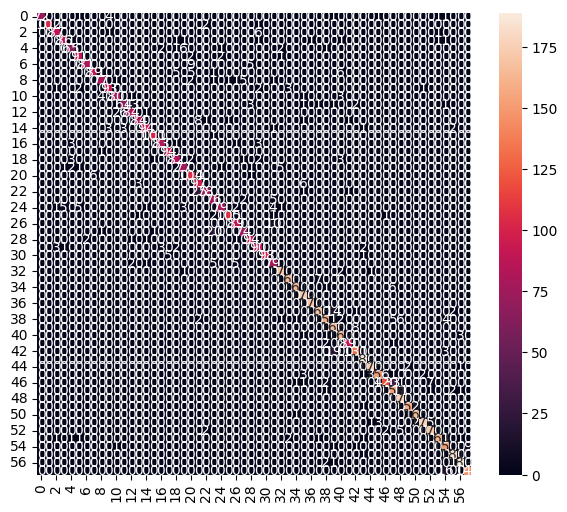

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        81
           1       1.00      0.97      0.99       105
           2       0.94      0.92      0.93        95
           3       0.92      0.91      0.92        94
           4       0.87      0.83      0.85        78
           5       0.90      0.95      0.92        96
           6       0.98      0.85      0.91        95
           7       0.94      0.83      0.88       107
           8       0.92      0.87      0.89        89
           9       0.92      0.91      0.92       102
          10       0.94      0.90      0.92        89
          11       0.88      0.74      0.80        87
          12       0.83      0.90      0.87        93
          13       0.95      0.88      0.91        96
          14       0.96      0.90      0.93       104
          15       0.98      0.99      0.99       102
          16       0.94      0.91      0.93        91
     

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [18]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [19]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmpcl3epirs\assets


INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmpcl3epirs\assets


81664

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4
CPU times: total: 0 ns
Wall time: 0 ns
